#   Anomaly Detection with SVD decomposed signals

Simple exercise to compute the marginal log likelihood (data evidence) to determine when a signal contains an anomaly. Signals are decomposed to SVD space before training. Training is only done on clean data. 

In [1]:
import os
import numpy as np
import torch

path = "/Users/huylenguyen/digiLab/FM-digiLab-2025/data/raw/pipe01/set04"
files = [os.path.join(path, file) for file in os.listdir(path) if ".npy" in file]
path = "/Users/huylenguyen/digiLab/FM-digiLab-2025/data/raw/pipe01/set05"
files = files + [os.path.join(path, file) for file in os.listdir(path) if ".npy" in file]

clean_files = [file for file in files if "clean" in file]
defect_files = [file for file in files if "clean" not in file]

clean_files.sort()
defect_files.sort()

clean_X = torch.from_numpy(np.array([int(file[-8:-4])/100 for file in clean_files])[:, np.newaxis])
clean_y = torch.from_numpy(np.vstack([np.sum(np.load(file)[1:, :], axis=0) for file in clean_files]))
defect_X = torch.from_numpy(np.array([int(file[-8:-4])/100 for file in defect_files])[:, np.newaxis])
defect_y = torch.from_numpy(np.vstack([np.sum(np.load(file)[1:, :], axis=0) for file in defect_files]))

clean_X.shape, clean_y.shape, defect_X.shape, defect_y.shape

(torch.Size([16, 1]),
 torch.Size([16, 48079]),
 torch.Size([11, 1]),
 torch.Size([11, 48079]))

In [2]:
clean_files

['/Users/huylenguyen/digiLab/FM-digiLab-2025/data/raw/pipe01/set04/clean_64av_WX_A_1552.npy',
 '/Users/huylenguyen/digiLab/FM-digiLab-2025/data/raw/pipe01/set04/clean_64av_WX_B_1553.npy',
 '/Users/huylenguyen/digiLab/FM-digiLab-2025/data/raw/pipe01/set04/clean_64av_WX_C_1552.npy',
 '/Users/huylenguyen/digiLab/FM-digiLab-2025/data/raw/pipe01/set04/clean_64av_WX_D_1552.npy',
 '/Users/huylenguyen/digiLab/FM-digiLab-2025/data/raw/pipe01/set04/clean_64av_WX_E_1553.npy',
 '/Users/huylenguyen/digiLab/FM-digiLab-2025/data/raw/pipe01/set04/clean_64av_WX_F_1553.npy',
 '/Users/huylenguyen/digiLab/FM-digiLab-2025/data/raw/pipe01/set04/clean_64av_WX_G_1556.npy',
 '/Users/huylenguyen/digiLab/FM-digiLab-2025/data/raw/pipe01/set04/clean_64av_WX_H_1555.npy',
 '/Users/huylenguyen/digiLab/FM-digiLab-2025/data/raw/pipe01/set04/clean_64av_WX_I_1549.npy',
 '/Users/huylenguyen/digiLab/FM-digiLab-2025/data/raw/pipe01/set04/clean_64av_WX_J_1546.npy',
 '/Users/huylenguyen/digiLab/FM-digiLab-2025/data/raw/pipe01

In [3]:
defect_files

['/Users/huylenguyen/digiLab/FM-digiLab-2025/data/raw/pipe01/set04/BIGDEFECT_loc1_64av_WX_A_1551.npy',
 '/Users/huylenguyen/digiLab/FM-digiLab-2025/data/raw/pipe01/set04/BIGDEFECT_loc1_64av_WX_B_1551.npy',
 '/Users/huylenguyen/digiLab/FM-digiLab-2025/data/raw/pipe01/set04/BIGDEFECT_loc1_64av_WX_C_1551.npy',
 '/Users/huylenguyen/digiLab/FM-digiLab-2025/data/raw/pipe01/set04/BIGDEFECT_loc1_64av_WX_D_1552.npy',
 '/Users/huylenguyen/digiLab/FM-digiLab-2025/data/raw/pipe01/set04/BIGDEFECT_loc2_64av_WX_A_1552.npy',
 '/Users/huylenguyen/digiLab/FM-digiLab-2025/data/raw/pipe01/set04/BIGDEFECT_loc2_64av_WX_B_1553.npy',
 '/Users/huylenguyen/digiLab/FM-digiLab-2025/data/raw/pipe01/set04/BIGDEFECT_loc2_64av_WX_C_1552.npy',
 '/Users/huylenguyen/digiLab/FM-digiLab-2025/data/raw/pipe01/set04/BIGDEFECT_loc2_64av_WX_D_1549.npy',
 '/Users/huylenguyen/digiLab/FM-digiLab-2025/data/raw/pipe01/set05/MedDefect_A_1085.npy',
 '/Users/huylenguyen/digiLab/FM-digiLab-2025/data/raw/pipe01/set05/MedDefect_B_1084.np

In [4]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=15)
clean_y_svd = torch.from_numpy(tsvd.fit_transform(clean_y.numpy()))
defect_y_svd = torch.from_numpy(tsvd.transform(defect_y.numpy()))

In [5]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import GaussianLikelihood
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize
import matplotlib.pyplot as plt

# Define training data
train_X = clean_X#[:-1, :]  # Input points
train_Y = clean_y_svd#[:-1, :]  # Observations

# Define the GP model
gp_model = SingleTaskGP(
    train_X, 
    train_Y, 
    input_transform=Normalize(train_X.shape[1]), 
    outcome_transform=Standardize(train_Y.shape[1])
)

# Define likelihood and MLL (Marginal Log Likelihood)
likelihood = gp_model.likelihood
mll = ExactMarginalLogLikelihood(likelihood, gp_model)

# Fit the model to maximize the MLL
fit_gpytorch_mll(mll)

print("="*20)
print("CLEAN")
print("="*20)
# test observation
idx_clean = -1
new_X = clean_X[idx_clean, :].unsqueeze(0)  
new_Y = clean_y_svd[idx_clean, :].unsqueeze(0)

# Get the predictive distribution at new_X
with torch.no_grad():
    pred_dist = gp_model(gp_model.input_transform.transform(new_X))
# Compute the log marginal likelihood of the new observation
marginal_log_likelihood = mll(pred_dist, gp_model.outcome_transform(new_Y)[0].T).detach().squeeze()
# To get the marginal likelihood (not log), take the exponent
marginal_likelihood = torch.exp(marginal_log_likelihood)

print(f"Log Marginal Likelihood: {marginal_log_likelihood}")
print(f"Marginal Likelihood: {marginal_likelihood}")


print("="*20)
print("DEFECT")
print("="*20)
# test observation
idx_defect = 0
new_X_defect = defect_X[idx_defect, :].unsqueeze(0)  
new_Y_defect = defect_y_svd[idx_defect, :].unsqueeze(0)

# Get the predictive distribution at new_X
with torch.no_grad():
    pred_dist_defect = gp_model(gp_model.input_transform.transform(new_X_defect))

# Compute the log marginal likelihood of the new observation
marginal_log_likelihood_defect = mll(pred_dist_defect, gp_model.outcome_transform(new_Y_defect)[0].T).detach().squeeze()
# To get the marginal likelihood (not log), take the exponent
marginal_likelihood_defect = torch.exp(marginal_log_likelihood_defect)

print(f"Log Marginal Likelihood: {marginal_log_likelihood}")
print(f"Marginal Likelihood: {marginal_likelihood_defect}")

CLEAN
Log Marginal Likelihood: tensor([ -2.2404,   2.8540,  -0.7921,  -8.9336,  -9.1323,  -9.0058,  -8.4697,
         -9.0133,  -9.0271,  -9.2095,  -8.9360,  -9.5217, -10.8008,  -9.0980,
         -9.7106], dtype=torch.float64)
Marginal Likelihood: tensor([1.0641e-01, 1.7357e+01, 4.5288e-01, 1.3188e-04, 1.0811e-04, 1.2270e-04,
        2.0974e-04, 1.2178e-04, 1.2011e-04, 1.0008e-04, 1.3157e-04, 7.3248e-05,
        2.0383e-05, 1.1189e-04, 6.0639e-05], dtype=torch.float64)
DEFECT
Log Marginal Likelihood: tensor([ -2.2404,   2.8540,  -0.7921,  -8.9336,  -9.1323,  -9.0058,  -8.4697,
         -9.0133,  -9.0271,  -9.2095,  -8.9360,  -9.5217, -10.8008,  -9.0980,
         -9.7106], dtype=torch.float64)
Marginal Likelihood: tensor([4.6545e-11, 5.0777e-76, 4.5445e-08, 3.7021e-06, 1.3870e-04, 1.2516e-04,
        2.3578e-04, 5.5589e-05, 6.3993e-06, 4.4614e-05, 7.3413e-05, 5.9102e-05,
        4.1064e-07, 7.0300e-05, 1.3991e-04], dtype=torch.float64)


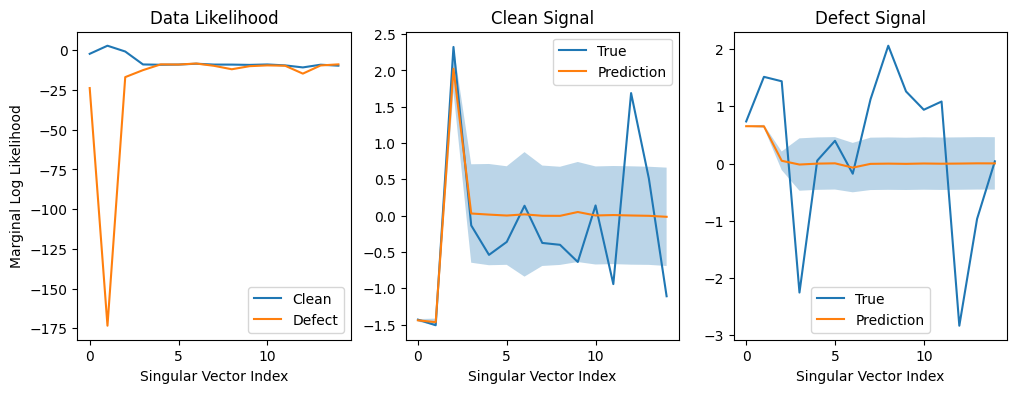

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(marginal_log_likelihood.detach(), label="Clean")
axes[0].plot(marginal_log_likelihood_defect.detach(), label="Defect")
axes[0].set_xlabel("Singular Vector Index")
axes[0].set_ylabel("Marginal Log Likelihood")
axes[0].set_title("Data Likelihood")
axes[0].legend()

clean_mean, clean_stdev = pred_dist.mean.detach().squeeze(), pred_dist.variance.sqrt().detach().squeeze()

axes[1].plot(gp_model.outcome_transform(new_Y)[0].squeeze(), label="True")
axes[1].plot(clean_mean, label="Prediction")
axes[1].fill_between(range(len(clean_mean)), clean_mean+1.96*clean_stdev, clean_mean-1.96*clean_stdev, alpha=0.3)
# axes[1].plot(pred_dist_defect.mean.detach().squeeze())
axes[1].set_xlabel("Singular Vector Index")
axes[1].set_title("Clean Signal")
axes[1].legend()

defect_mean, defect_stdev = pred_dist_defect.mean.detach().squeeze(), pred_dist_defect.variance.sqrt().detach().squeeze()

axes[2].plot(gp_model.outcome_transform(new_Y_defect)[0].squeeze(), label="True")
axes[2].plot(defect_mean, label="Prediction")
axes[2].fill_between(range(len(defect_mean)), defect_mean+1.96*defect_stdev, defect_mean-1.96*defect_stdev, alpha=0.3)
axes[2].set_xlabel("Singular Vector Index")
axes[2].set_title("Defect Signal")
axes[2].legend()

plt.show()